The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


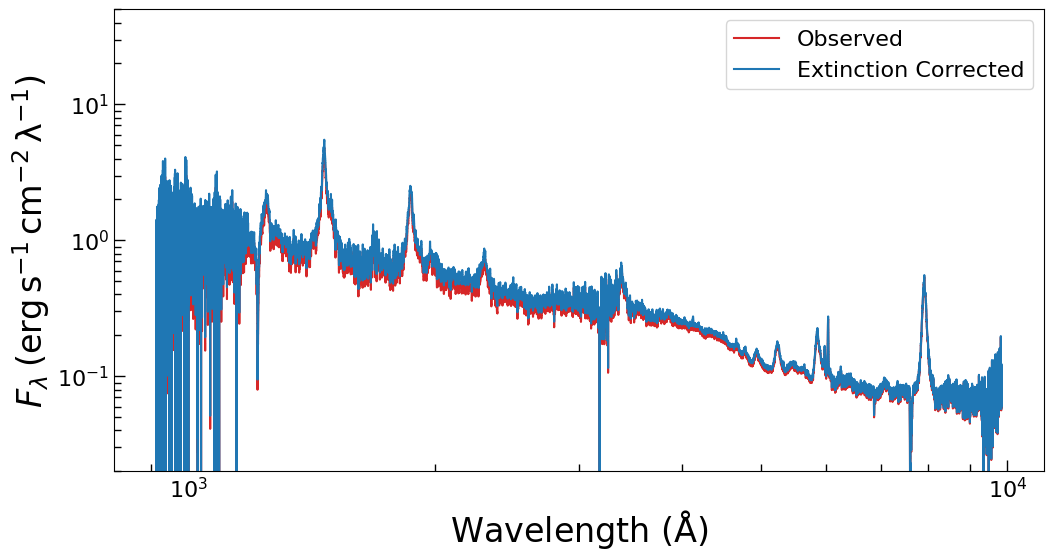

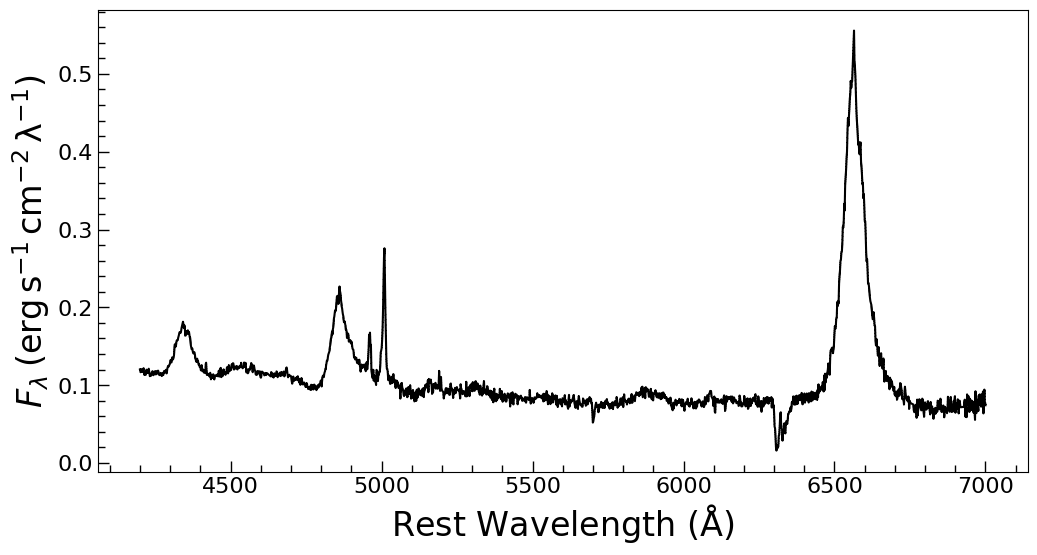

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg0947sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.053    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.2057 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

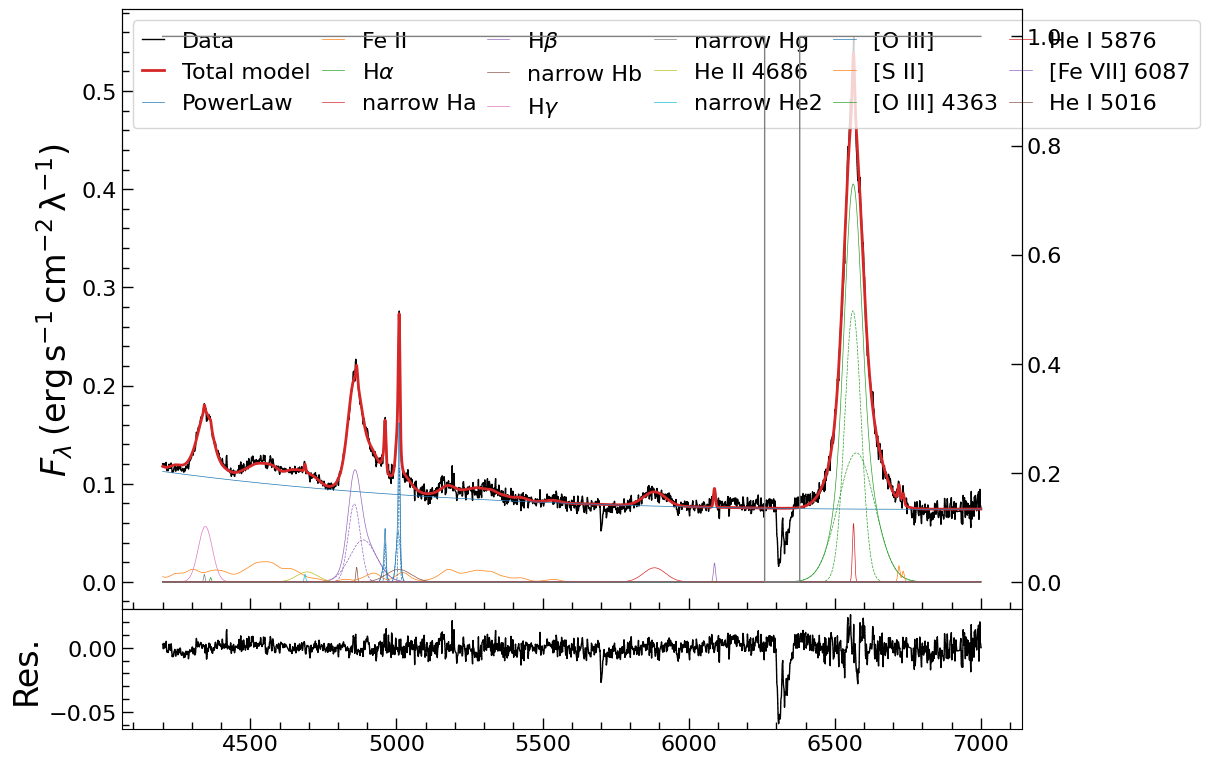

<PowerLaw1D(amplitude=0.07498534, x_0=5500., alpha=1.24885433, name='PowerLaw')>
<IronTemplate(amplitude=0.02677593, stddev=1413.4525, z=0.00037911, name='Fe II')>
<Line_MultiGauss(amp_c=0.22398193, dv_c=-41.51131916, sigma_c=1282.74691532, wavec=6562.819, amp_w0=0.47488444, dv_w0=514.67049303, sigma_w0=2850.36181492, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.04817245, dv=56.69397114, sigma=169.05096553, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.07546717, dv_c=-436.09359845, sigma_c=1288.51228262, wavec=4862.721, amp_w0=0.53850855, dv_w0=1867.72589343, sigma_w0=2809.00107879, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.01408959, dv=56.69397114, sigma=169.05096553, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.05319154, dv_c=280.35352679, sigma_c=1658.40206762, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.00711115, dv=56.69397114, sigma=169.05096553, wavec=4341.785, name='narrow Hg')>
<Line_MultiGauss(amp_c=0.00963305, dv_c=500., 

In [29]:
#------------------------------------------------------------具体拟合，修改各成分
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=2, name='multi')
pl = models.PowerLaw1D(amplitude=0.07498534, x_0=5500, alpha=1.24885433, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')
iron = sagan.IronTemplate(amplitude=0.02677593, stddev=1413.4525, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000),'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.3, dv_c=-12, sigma_c=1300, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.37, dv_w0=640, sigma_w0=3300)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.08, dv_c=-428, sigma_c=1400, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],bounds=bounds)
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.08, dv_c=-410, sigma_c=1350, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.42, dv_w0=-100, sigma_w0=3000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.057, dv_c=270, sigma_c=1800, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=500, sigma_c=2200, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.014, dv_c=450, sigma_c=2000, wavec=5875.624, name='He I 5876')  # Masked
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.12, amp_c1=0.04, dv_c=50, sigma_c=180, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.41, dv_w0=-170, sigma_w0=590)
#line_o3 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.11, amp_c1=0.04, dv_c=51, sigma_c=170, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]')
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.015, amp_c1=0.012,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=0.3, dv_c=-20, sigma_c=200,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=0.06, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.015, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.0087, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.007, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.004, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')

n_fe7_6087 = sagan.Line_Gaussian(amplitude=0.02, wavec=wave_dict['FeVII_6087'], name=f'[Fe VII] 6087')
b_he1_5016= sagan.Line_MultiGauss(n_components=1, amp_c=0.02, dv_c=-200, sigma_c=1500, wavec=5016, name='He I 5016',bounds=bounds)

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked

m_init = (pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+n_fe7_6087+b_he1_5016)*poly
#pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+n_fe7_6087

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363, n_fe7_6087]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
#fltr1 = (wave_use > 5770) & (wave_use < 6000)
fltr2 = (wave_use > 6260) & (wave_use < 6380)
fltr11 = (wave_use > 4275) & (wave_use < 4430)
fltr12 = (wave_use > 4600) & (wave_use < 5080)
fltr13 = (wave_use > 5550) & (wave_use < 6050)
fltr14 = (wave_use > 6200) & (wave_use < 6800)

#weights[fltr1] = 0.0
weights[fltr2] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())